In [1]:
import torch
%matplotlib inline

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import os
import sys
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm

from ast import literal_eval

""
sns.set_context("notebook", font_scale=1.5)
plt.rcParams['figure.figsize'] = (17, 5)

import platform
if 'Windows' in platform.platform():
    ROOT_PATH = "D:/PycharmProjects/HMAN"
else:
    ROOT_PATH = "/home/xkliu/PycharmProjects/HMAN"
RAW_DATA_PATH = ROOT_PATH  + "/raw_data"
DATA_PATH = ROOT_PATH + "/data"
os.chdir(ROOT_PATH)
sys.path.append("./")

from kddirkit.utils import utils


In [2]:
import logging
import torch.nn as nn
import numpy as np

from kddirkit.networks.encoders import SentenceEncoder
from kddirkit.networks.models import BaselineModel
from kddirkit.config import *
# from kddirkit.dataloaders import LoadNYT, LoadHierData
from kddirkit.frameworks import Trainer
from kddirkit.losses.FocalLoss import FocalLoss

project_name = 'HMAN'

logger = logging.getLogger(project_name)

## 1. Load Data

In [3]:
track_dtype = {'track_id': int, 'album_id': int, 'album_type': str, 'artist_id': int, 'set_split': str,
               'set_subset': str, 'track_genre_top': str, 'track_genres': str, 'track_genres_all': str,
               'track_title': str}
genres_converters = {'track_genres': literal_eval, 'track_genres_all': literal_eval}
medium_data = pd.read_csv(RAW_DATA_PATH + '/medium_data.csv', converters=genres_converters)

In [4]:
medium_data_train = pd.read_csv(RAW_DATA_PATH + '/medium_data_train.csv', converters=genres_converters)
medium_data_test = pd.read_csv(RAW_DATA_PATH + '/medium_data_test.csv', converters=genres_converters)
medium_data_val = pd.read_csv(RAW_DATA_PATH + '/medium_data_val.csv', converters=genres_converters)

In [5]:
medium_instance_triple = np.load(DATA_PATH + '/' + 'medium_instance_triple.npy')
medium_instance_scope = np.load(DATA_PATH + '/' + 'medium_instance_scope.npy')
medium_label = np.load(DATA_PATH + '/' + 'medium_label.npy')

In [6]:
medium_train_instance_triple = np.load(DATA_PATH + '/' + 'medium_train_instance_triple.npy')
medium_train_instance_scope = np.load(DATA_PATH + '/' + 'medium_train_instance_scope.npy')
medium_train_label = np.load(DATA_PATH + '/' + 'medium_train_label.npy')

In [7]:
medium_val_instance_triple = np.load(DATA_PATH + '/' + 'medium_val_instance_triple.npy')
medium_val_instance_scope = np.load(DATA_PATH + '/' + 'medium_val_instance_scope.npy')
medium_val_label = np.load(DATA_PATH + '/' + 'medium_val_label.npy')

In [8]:
medium_test_entity_pair = np.load(DATA_PATH + '/' + 'medium_test_entity_pair.npy')
medium_test_entity_scope = np.load(DATA_PATH + '/' + 'medium_test_entity_scope.npy')
medium_test_label = np.load(DATA_PATH + '/' + 'medium_test_label.npy')

In [9]:
medium_label_transform = np.load(DATA_PATH + '/' + 'medium_label_transform.npy')
medium_train_label_transform = np.load(DATA_PATH + '/' + 'medium_train_label_transform.npy')
medium_val_label_transform = np.load(DATA_PATH + '/' + 'medium_val_label_transform.npy')
medium_test_label_transform = np.load(DATA_PATH + '/' + 'medium_test_label_transform.npy')
medium_label_bottom_transform = np.load(DATA_PATH + '/' + 'medium_label_bottom_transform.npy')
medium_train_label_bottom_transform = np.load(DATA_PATH + '/' + 'medium_train_label_bottom_transform.npy')
medium_val_label_bottom_transform = np.load(DATA_PATH + '/' + 'medium_val_label_bottom_transform.npy')
medium_test_label_bottom_transform = np.load(DATA_PATH + '/' + 'medium_test_label_bottom_transform.npy')

In [10]:
col_name = ['track_id', 'album_id', 'album_type', 'artist_id', 'set_split', 'set_subset', 'track_genres_top', 'track_genre', 'track_genres_all']
medium_data_train_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_train_sort.txt', sep ='-----',  skiprows =1, names  = col_name)
medium_data_val_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_VAL_sort.txt', sep = '-----',  skiprows =1, names  = col_name)
medium_data_test_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_test_sort.txt', sep = '-----', skiprows =1, names  = col_name)

C:\Users\Johan\AppData\Local\Temp\ipykernel_64284\691608824.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  medium_data_train_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_train_sort.txt', sep ='-----',  skiprows =1, names  = col_name)
C:\Users\Johan\AppData\Local\Temp\ipykernel_64284\691608824.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  medium_data_val_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_VAL_sort.txt', sep = '-----',  skiprows =1, names  = col_name)
C:\Users\Johan\AppData\Local\Temp\ipykernel_64284\691608824.py:4: ParserWarning: Falling back to the 'python' engine 

In [11]:
medium_data

,track_id,album_id,album_type,artist_id,set_split,set_subset,track_genre_top,track_genres,track_genres_all,track_title
0,2,1,Album,1,training,small,Hip-Hop,[21],[21],Food
1,5,1,Album,1,training,small,Hip-Hop,[21],[21],This World
2,10,6,Album,6,training,small,Pop,[10],[10],Freeway
3,140,61,Album,54,training,small,Folk,[17],[17],Queen Of The Wires
4,141,60,Album,54,training,small,Folk,[17],[17],Ohio
...,...,...,...,...,...,...,...,...,...,...
24995,155297,22935,Album,24354,training,medium,Instrumental,"[18, 107, 1235]","[107, 18, 1235]",Nebula Reborn
24996,155298,22936,Album,22050,training,medium,Folk,"[17, 103]","[17, 103]",An Idiot Abroad
24997,155306,22936,Album,22050,training,medium,Folk,"[17, 103]","[17, 103]",Tiny Man
24998,155307,22937,Live Performance,7820,training,medium,Experimental,[1],"[1, 38]",Kolka


In [12]:
medium_data_train_sort

,track_id,album_id,album_type,artist_id,set_split,set_subset,track_genres_top,track_genre,track_genres_all
0,2,1,Album,1,training,small,Hip-Hop,[21],[21]
1,5,1,Album,1,training,small,Hip-Hop,[21],[21]
2,3,1,Album,1,training,medium,Hip-Hop,[21],[21]
3,134,1,Album,1,training,medium,Hip-Hop,[21],[21]
4,10666,1,Album,1,training,medium,Hip-Hop,[21],[21]
...,...,...,...,...,...,...,...,...,...
19917,155297,22935,Album,24354,training,medium,Instrumental,"[18, 107, 1235]","[107, 18, 1235]"
19918,155298,22936,Album,22050,training,medium,Folk,"[17, 103]","[17, 103]"
19919,155306,22936,Album,22050,training,medium,Folk,"[17, 103]","[17, 103]"
19920,155307,22937,Live Performance,7820,training,medium,Experimental,[1],"[1, 38]"


In [13]:
# Load metadata and features.
tracks = utils.load(RAW_DATA_PATH + '/fma_metadata/tracks.csv')
genres = utils.load(RAW_DATA_PATH + '/fma_metadata/genres.csv')
features = utils.load(RAW_DATA_PATH + '/fma_metadata/features.csv')
echonest = utils.load(RAW_DATA_PATH + '/fma_metadata/echonest.csv')

In [14]:
medium_data_train_sort.track_id

0             2
1             5
2             3
3           134
4         10666
          ...  
19917    155297
19918    155298
19919    155306
19920    155307
19921    155314
Name: track_id, Length: 19922, dtype: int64

In [15]:
small = tracks['set', 'subset'] <= 'medium'

train = tracks['set', 'split'] == 'training'
small = tracks['set', 'subset'] <= 'medium'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[medium_data_train_sort.track_id, ('track', 'genre_top')]
y_val = tracks.loc[medium_data_val_sort.track_id, ('track', 'genre_top')]
y_test = tracks.loc[medium_data_test_sort.track_id, ('track', 'genre_top')]
X_train = features.loc[medium_data_train_sort.track_id, 'mfcc']
X_val= features.loc[medium_data_val_sort.track_id, 'mfcc']
X_test = features.loc[medium_data_test_sort.track_id, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

19922 training examples, 2573 testing examples
140 features, 16 classes


In [16]:
from sklearn.neural_network import MLPClassifier

# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)


X_train_np = np.array(X_train).astype('float32')
X_test_np = np.array(X_test).astype('float32')
X_val_np = np.array(X_val).astype('float32')

y_train_np = np.argmax(pd.get_dummies(y_train).to_numpy(), axis=1)
y_test_np = np.argmax(pd.get_dummies(y_test).to_numpy(), axis = 1)
y_val_np = np.argmax(pd.get_dummies(y_val).to_numpy(), axis = 1)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.


C:\Users\Johan\anaconda3\envs\HMAN\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Johan\anaconda3\envs\HMAN\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Johan\anaconda3\envs\HMAN\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


array([[ 2.68300051,  0.75385087,  1.75008045, ..., -0.39059965,
        -0.66829634, -0.62860366],
       [-0.0364069 , -0.41132161, -0.34856613, ...,  0.37020135,
         0.28991045,  0.91080142],
       [-0.09969836, -0.48945548,  0.04735517, ...,  0.17109902,
         0.14077713,  0.01436047],
       ...,
       [-0.21710572, -0.61654383, -0.19618588, ...,  0.55899703,
         1.18222817,  0.72873298],
       [-0.40553948, -0.38936326, -0.36861813, ..., -0.29028054,
        -0.16343454, -0.19068153],
       [-0.27282894, -0.56695434, -0.14396324, ..., -1.12420629,
        -0.09533861, -0.44360725]])

In [17]:
# clf = MLPClassifier()
# clf.fit(X_train_np, y_train_np)
# score = clf.score(X_test_np, y_test_np)
# print('Accuracy: {:.2%}'.format(score))

Accuracy: 57.75%


# Train

In [27]:
from kddirkit.networks.encoders import SentenceEncoder
from kddirkit.networks.models import BaselineModel
from kddirkit.config import *
from kddirkit.dataloaders import LoadFMA, LoadHierData
from kddirkit.frameworks import Trainer
from kddirkit.losses.FocalLoss import FocalLoss

parser = Parser(ROOT_PATH + "/data/config", "HMAN")
oneParser = parser.oneParser
args, _ = oneParser.parse_known_args(args=[])
args = vars(args)

In [28]:
use_cuda = not args['no_cuda'] and torch.cuda.is_available()

torch.manual_seed(args['seed'])

device = torch.device("cuda" if use_cuda else "cpu")

HierDataLoader = LoadHierData.HierDataLoader(workdir=os.getcwd(), pattern='default', device=device)
genre_levels_Tensor = HierDataLoader.genre_levels_Tensor.to(device)
genre_level_layer = HierDataLoader.genre_level_layer

trainDataLoader = LoadFMA.FMATrainDataLoader(device=device)
testDataLoader = LoadFMA.FMATestDataLoader(mode="pr", device=device)

In [29]:
# class MLP(nn.Module):
#   def __init__(self, input_size, common_size):
#     super(MLP, self).__init__()
#     self.linear = nn.Sequential(
#       nn.Linear(input_size, common_size),
#       nn.LogSoftmax(inplace=True)
#       # nn.ReLU(inplace=True)
#     )
#
#   def forward(self, x):
#     out = self.linear(x)
#     return out

In [66]:
class MLP(nn.Module):
    def __init__(self, num_units, out_units, dropout=0.1):
        super(MLP, self).__init__()
        self.num_units = num_units
        self.linear_1 = nn.Linear(140, 100)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(100, out_units)

    def forward(self, x):

        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.softmax(x, dim=-1)

        return x

In [67]:
# class MLP(nn.Module):
#     def __init__(self, num_units, out_units, dropout=0.1):
#         super(MLP, self).__init__()
#         self.num_units = num_units
#         self.linear_1 = nn.Linear(140, 100)
#         self.dropout = nn.Dropout(dropout)
#         self.linear_2 = nn.Linear(100, 10)
#         self.linear_3 = nn.Linear(10, out_units)
#
#     def forward(self, x):
#
#         x = self.linear_1(x)
#         x = F.relu(x)
#         x = self.linear_2(x)
#         x = F.relu(x)
#         x = self.linear_3(x)
#         x = F.softmax(x, dim=-1)
#
#         return x

In [68]:
# fma_data = torch.rand((3, 140)).to(args.device)
# test_module = MLP(140, 16).to(args.device)
# test_module(fma_data)

In [72]:
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch import optim
import torch.nn.functional as F
class argparse():
    pass
args = argparse()
args.epochs, args.learning_rate, args.patience = [400, 0.001, 4]
# args.hidden_size, args.input_size= [40, 30]
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.Tensor(X_train_np)
X_test_tensor = torch.Tensor(X_test_np)
X_val_tensor = torch.Tensor(X_val_np)

# y_train_tensor = torch.LongTensor(pd.get_dummies(y_train).to_numpy()).to(args.device)
# y_test_tensor = torch.LongTensor(pd.get_dummies(y_test).to_numpy()).to(args.device)
# y_val_tensor = torch.LongTensor(pd.get_dummies(y_val).to_numpy()).to(args.device)

y_train_tensor = np.zeros((len(y_train_np) , 16))  # 相当于 做了一个onehot_dict
y_train_tensor[np.arange(len(y_train_np) ), y_train_np] = 1  # 为onehot_dict 赋值
y_train_tensor = torch.LongTensor(y_train_tensor)
y_test_tensor = np.zeros((len(y_test_np) , 16))  # 相当于 做了一个onehot_dict
y_test_tensor[np.arange(len(y_test_np) ), y_test_np] = 1  # 为onehot_dict 赋值
y_test_tensor = torch.LongTensor(y_test_tensor)

y_val_tensor = np.zeros((len(y_val_np) , 16))  # 相当于 做了一个onehot_dict
y_val_tensor[np.arange(len(y_val_np) ), y_val_np] = 1  # 为onehot_dict 赋值
y_val_tensor = torch.LongTensor(y_val_tensor)


train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
test_dataset=TensorDataset(X_test_tensor,y_test_tensor)
val_dataset=TensorDataset(X_val_tensor,y_val_tensor)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=1000 , shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1000, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,batch_size=1000, shuffle=True)

In [73]:
# class EarlyStopping():
#     def __init__(self,patience=7,verbose=False,delta=0):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = np.Inf
#         self.delta = delta
#     def __call__(self,val_loss,model,path):
#         print("val_loss={}".format(val_loss))
#         score = -val_loss
#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(val_loss,model,path)
#         elif score < self.best_score+self.delta:
#             self.counter+=1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter>=self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(val_loss,model,path)
#             self.counter = 0
#     def save_checkpoint(self,val_loss,model,path):
#         if self.verbose:
#             print(
#                 f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), path+'/'+'model_checkpoint.pth')
#         self.val_loss_min = val_loss

In [77]:
accuracy_list = []
model = MLP(140, 16).to(args.device)

parameters_to_optimize = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(parameters_to_optimize, lr =  args.learning_rate, betas = [0.9, 0.999], eps= 0.00000001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss().to(args.device)
# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    accuracy_sum = 0.0
    step = 0.0
    for idx,(data_x,data_y) in enumerate(train_dataloader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = model(data_x)
        optimizer.zero_grad()
        loss = criterion(outputs, data_y)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        predictions = outputs
        correct_predictions = torch.eq(torch.argmax(predictions, axis= 1), torch.argmax(data_y, axis=1))
        accuracy = torch.mean(correct_predictions.float())
        accuracy_sum += accuracy
        step += 1
        if idx%(len(train_dataloader)//2)==0:
            model.eval()
            predictions = model(X_test_tensor.to(args.device))
            correct_predictions = torch.eq(torch.argmax(predictions, axis= 1), torch.tensor(y_test_np).to(args.device))
            accuracy = torch.mean(correct_predictions.float())
            accuracy_list.append(accuracy.cpu().numpy())
            print("epoch={}/{},{}/{} of train, loss={}, training accuracy = {}, testing accuracy = {}".format(
            epoch, args.epochs, idx, len(train_dataloader),loss.item(), accuracy_sum/step, accuracy))

    train_epochs_loss.append(np.average(train_epoch_loss))

    #=====================valid============================
    # model.eval()
    # predictions = model(X_test_tensor.to(args.device))
    # correct_predictions = torch.eq(torch.argmax(predictions, axis= 1), torch.tensor(y_test_np).to(args.device))
    # accuracy = torch.mean(correct_predictions.float())
    # accuracy_list.append(accuracy.cpu().numpy())



epoch=0/400,0/20 of train, loss=2.8721954822540283, training accuracy = 0.0010000000474974513, testing accuracy = 0.032258063554763794
epoch=0/400,10/20 of train, loss=2.560014009475708, training accuracy = 0.23227275907993317, testing accuracy = 0.2922658324241638
epoch=1/400,0/20 of train, loss=2.565474033355713, training accuracy = 0.30900001525878906, testing accuracy = 0.29848426580429077
epoch=1/400,10/20 of train, loss=2.586824417114258, training accuracy = 0.30372729897499084, testing accuracy = 0.303148090839386
epoch=2/400,0/20 of train, loss=2.547996759414673, training accuracy = 0.32500001788139343, testing accuracy = 0.30275943875312805
epoch=2/400,10/20 of train, loss=2.5994064807891846, training accuracy = 0.30618181824684143, testing accuracy = 0.30392539501190186
epoch=3/400,0/20 of train, loss=2.549370050430298, training accuracy = 0.3240000009536743, testing accuracy = 0.30509135127067566
epoch=3/400,10/20 of train, loss=2.560255527496338, training accuracy = 0.31372

KeyboardInterrupt: 

In [ ]:
from skorch import NeuralNetClassifier
mnn = NeuralNetClassifier(model, max_epochs=200, lr=0.001, batch_size=1000, optimizer=optim.Adam)
mnn.fit(X_train_np.astype('float32'), y_train_np)
mnn.score(X_test_np.astype('float32'), y_test_np)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       11.8102       0.2873       10.5074  0.2096
      2        9.5671       0.3006        7.6398  0.1742
      3        6.3234       0.4417        5.6509  0.1664
      4        4.9749       0.4695        4.6270  0.1949
      5        4.5180       0.4906        4.4737  0.1713
      6        4.4114       0.5122        4.4009  0.1749
      7        4.3563       0.5092        4.3780  0.1786
      8        4.3191       0.5184        4.3241  0.5048
      9        4.2812       0.5177        4.3176  0.1849
     10        4.2652       0.5205        4.3063  0.1823
     11        4.2532       0.5212        4.3001  0.2016
     12        4.2435       0.5245        4.2898  0.1921
     13        4.2338       0.5270        4.2875  0.1830
     14        4.2278       0.5282        4.2804  0.1994
     15        4.2208       0.5280        4.2734  0.1870
     16        4.2145       0.5

In [53]:
from skorch import NeuralNetClassifier
mnn = NeuralNetClassifier(model, max_epochs=200, lr=0.001, batch_size=10000, optimizer=optim.Adam)
mnn.fit(X_train_tensor, y_train_np)
mnn.score(X_test_tensor, y_test_np)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       12.5939       0.2853       11.3535  0.1609
      2       11.3523       0.2853       11.3394  0.3182
      3       11.3258       0.2806       11.2865  0.1542
      4       11.2802       0.2550       11.2765  0.1696
      5       11.2668       0.2811       11.2173  0.1548
      6       11.2117       0.2821       11.1095  0.3277
      7       11.0322       0.2740       10.4300  0.1714
      8       10.0647       0.2725        8.6569  0.1678
      9        8.6447       0.2846        9.0050  0.1814
     10        8.8207       0.3297        8.3144  0.1659
     11        8.2489       0.3440        8.3719  0.3109
     12        8.2807       0.3834        7.8219  0.1727
     13        7.7109       0.3729        7.6684  0.1787
     14        7.5570       0.4141        7.1072  0.1733
     15        7.0532       0.3656        7.0971  0.4502
     16        7.0621       0.3

0.5301204819277109

In [190]:
X_train_tensor

tensor([[ 2.1610,  4.0913,  1.3561,  ...,  5.5406,  5.8819,  5.3047],
        [ 2.9958,  0.6376,  0.2148,  ...,  6.6153,  5.6904,  6.6683],
        [ 3.9623,  5.9557,  0.6369,  ...,  8.0138,  7.3404,  6.9348],
        ...,
        [15.3014,  2.5558,  1.1593,  ...,  6.6224,  6.6642,  6.7467],
        [14.8685,  0.3737, -0.0997,  ...,  8.0130,  8.1268,  7.4578],
        [-0.1349,  0.9803, -0.0680,  ...,  6.1940,  6.3627,  6.5727]])

In [191]:
X_train_tensor

tensor([[ 2.1610,  4.0913,  1.3561,  ...,  5.5406,  5.8819,  5.3047],
        [ 2.9958,  0.6376,  0.2148,  ...,  6.6153,  5.6904,  6.6683],
        [ 3.9623,  5.9557,  0.6369,  ...,  8.0138,  7.3404,  6.9348],
        ...,
        [15.3014,  2.5558,  1.1593,  ...,  6.6224,  6.6642,  6.7467],
        [14.8685,  0.3737, -0.0997,  ...,  8.0130,  8.1268,  7.4578],
        [-0.1349,  0.9803, -0.0680,  ...,  6.1940,  6.3627,  6.5727]])

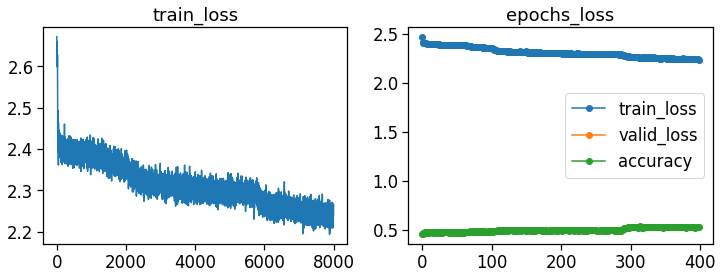

In [81]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
plt.plot(valid_epochs_loss[1:],'-o',label="valid_loss")
plt.plot(accuracy_list[1:],'-o',label="accuracy")
plt.title("epochs_loss")
plt.legend()
plt.show()

In [82]:
from model.attention.SelfAttention import ScaledDotProductAttention
import torch

input=torch.randn(50,49,512)
sa = ScaledDotProductAttention(d_model=16, d_k=140, d_v=140, h=8)
output=sa(input,input,input)
print(output.shape)

torch.Size([50, 49, 512])
